In [1]:
%load_ext jupyter_black

In [2]:
from IPython.core.display import Image

import datetime

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

import fast_spa

ZENITH_ANGLE = 0
AZIMUTH_ANGLE = 1

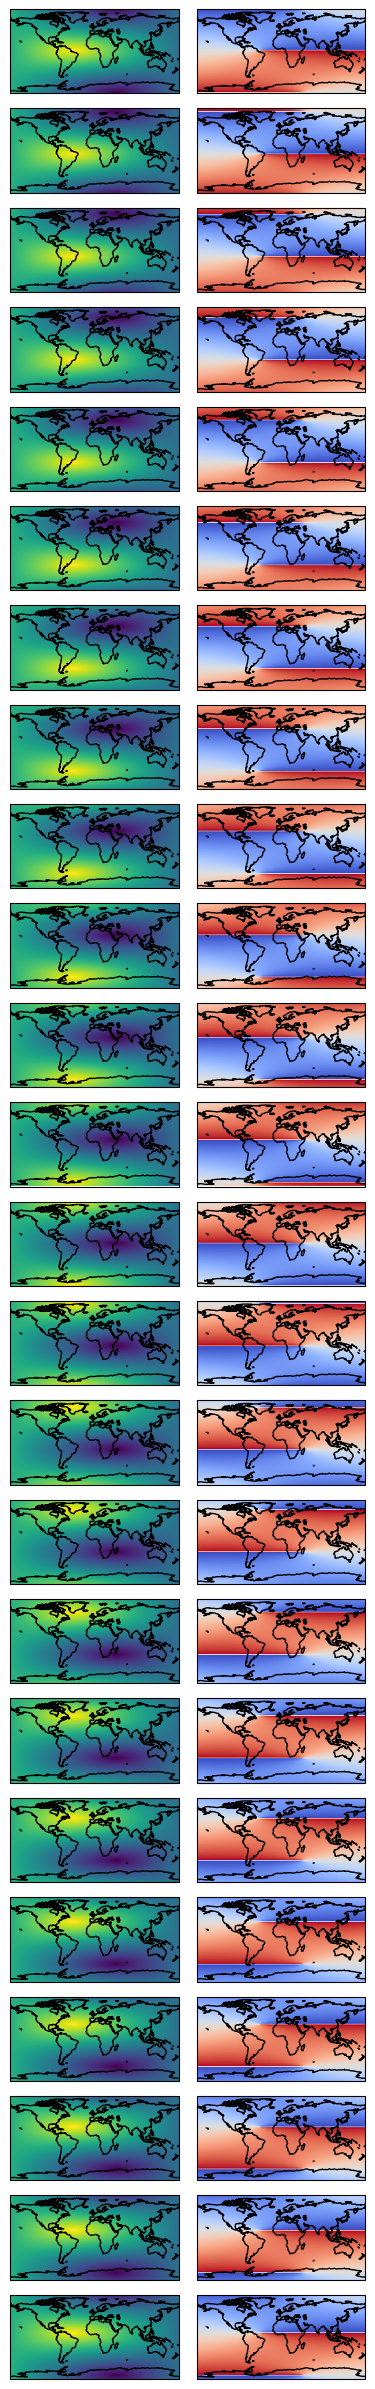

In [3]:
# CONUS


lats = np.linspace(-90, 90, 100)
lons = np.linspace(-180, 180, 200)
lats, lons = np.meshgrid(lats, lons)

channels = [ZENITH_ANGLE, AZIMUTH_ANGLE]
name = ["zenith", "azimuth"]


datetime_obj = np.arange("2023-07-01", "2023-07-02", dtype="datetime64[h]")[
    :24
].astype("datetime64[ns]")


def plot_data(data):
    fig, axes = plt.subplots(
        len(datetime_obj),
        len(channels),
        figsize=(2 * len(channels), len(datetime_obj)),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )
    fig.tight_layout()
    extent = [lons.min(), lons.max(), lats.min(), lats.max()]
    for i in range(len(datetime_obj)):
        ax1, ax2 = axes[i]
        zen, azi = data[:, i]
        ax1.coastlines()
        ax1.imshow(
            zen,
            origin="lower",
            extent=extent,
        )

        ax2.coastlines()
        ax2.imshow(
            azi,
            origin="lower",
            extent=extent,
            cmap="coolwarm",
            # **MIN_MAX[AZIMUTH_ANGLE],
        )
        # ax2.set_title(f"azimuth angle {datetime_obj[i]}")


data = np.radians(fast_spa.fast_spa(datetime_obj, lats, lons))

plot_data(data)

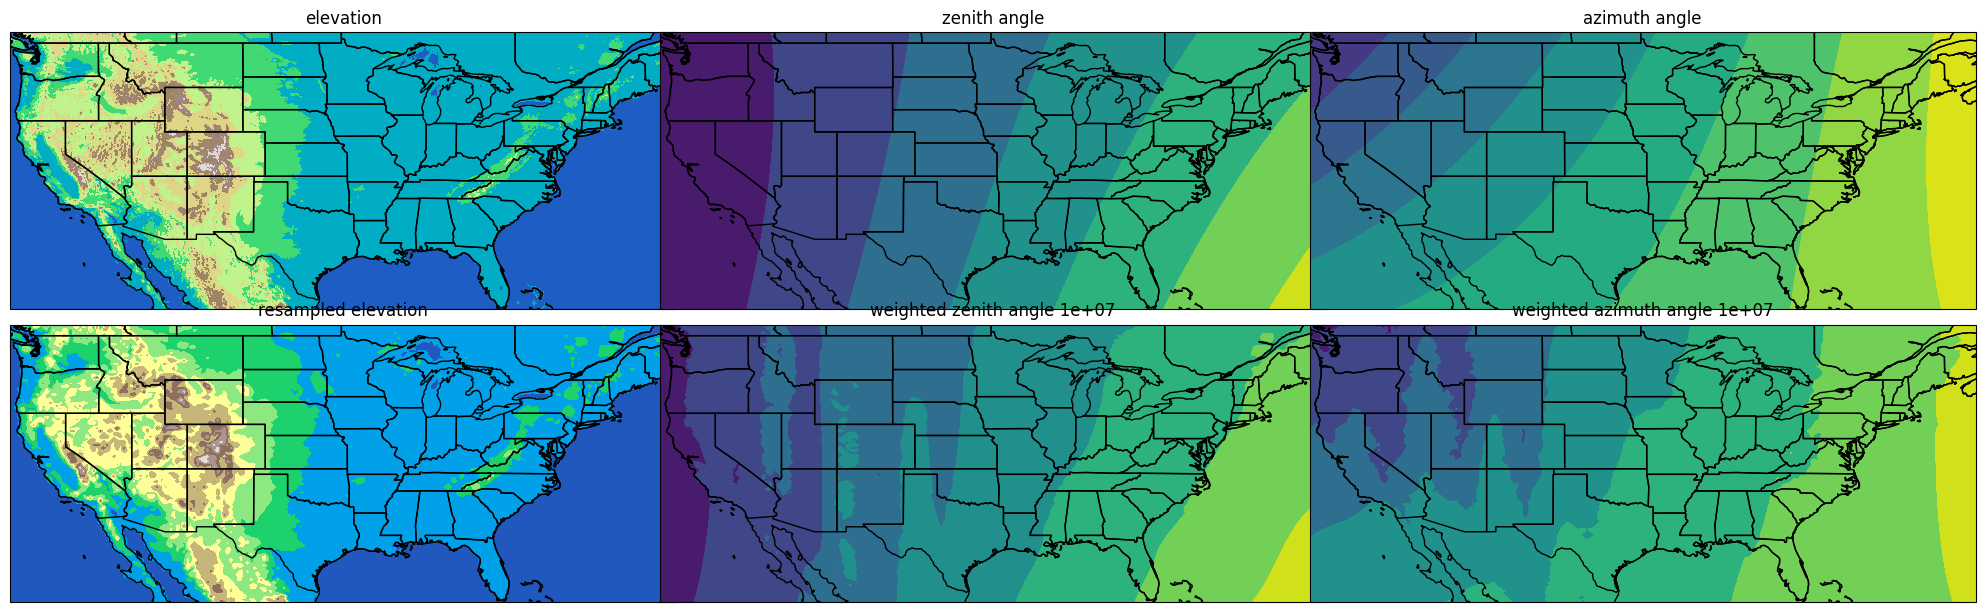

In [10]:
from numpy.typing import ArrayLike


def contourf(
    ax: GeoAxes,
    data: ArrayLike,
    lons: ArrayLike,
    lats: ArrayLike,
    title="",
    **kwargs,
) -> GeoAxes:
    ax.title.set_text(title)
    ax.coastlines()
    ax.add_feature(cfeature.STATES)
    ax.contourf(
        lons,
        lats,
        data,
        transform=ccrs.PlateCarree(),
        **kwargs,
    )
    return ax


def main(
    etopo: fast_spa.ETOPO2022 = fast_spa.ETOPO2022(),
    lons=np.linspace(-125, -65, 200),
    lats=np.linspace(25, 50, 100),
    weight: float = 1e7,
):
    fig, axes = plt.subplots(
        2, 3, figsize=(20, 6), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    # - plot the non-resampled elevation data
    lons, lats = np.meshgrid(lons, lats)
    y_mask = np.logical_and(etopo.lat >= lats.min(), etopo.lat <= lats.max())
    x_mask = np.logical_and(etopo.lon >= lons.min(), etopo.lon <= lons.max())

    fig.tight_layout()

    e = etopo[y_mask, x_mask]
    e[e < -100] = -100  # set the ocean to -100m

    contourf(
        axes[0, 0],
        e,
        etopo.lon[x_mask],
        etopo.lat[y_mask],
        "elevation",
        cmap="terrain",
    )
    # resample the elevation data to fit the lats and lons
    e = etopo.resample(lons, lats)
    e[e < -100] = -100  # set the ocean to -100m

    spa_data = fast_spa.fast_spa(datetime_obj, lats, lons, e)

    weighted = fast_spa.fast_spa(
        datetime_obj, lats, lons, e * weight
    )  # apply a weight to the elevation data for SPA calculation
    weighted = np.radians(weighted)

    contourf(
        axes[1, 0],
        e,
        lons,
        lats,
        "resampled elevation",
        cmap="terrain",
    )

    contourf(
        axes[0, 1],
        spa_data[ZENITH_ANGLE, 0, :, :],
        lons,
        lats,
        "zenith angle",
    )
    contourf(
        axes[1, 1],
        weighted[ZENITH_ANGLE, 0, :, :],
        lons,
        lats,
        f"weighted zenith angle {weight:.0e}",
    )

    contourf(
        axes[0, 2],
        spa_data[AZIMUTH_ANGLE, 0, :, :],
        lons,
        lats,
        "azimuth angle",
    )
    contourf(
        axes[1, 2],
        weighted[AZIMUTH_ANGLE, 0, :, :],
        lons,
        lats,
        f"weighted azimuth angle {weight:.0e}",
    )
    plt.show()


main()

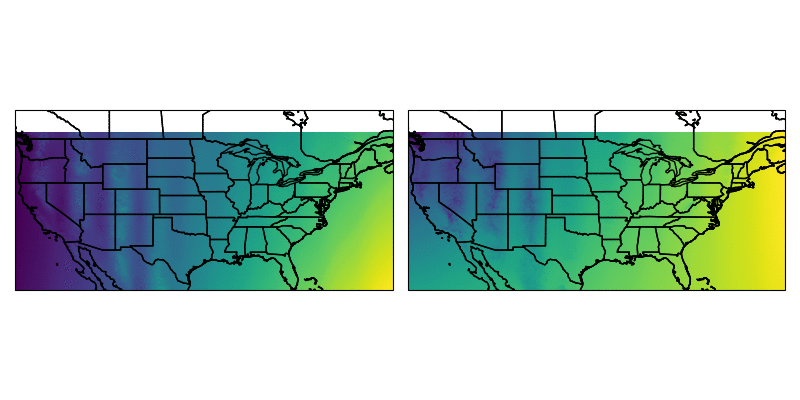

In [5]:
import fast_spa.display
from matplotlib.colors import ListedColormap

# ----------------
kind = ""

datetime_obj = np.arange("2023-07-01", "2023-07-02", dtype="datetime64[h]")[
    :24
].astype("datetime64[ns]")
# - colorado
if kind == "COLORADO":
    lats = np.linspace(36, 45, 100)
    lons = np.linspace(-110, -90, 200)
else:
    lats = np.linspace(-90, 90, 100)
    lons = np.linspace(-180, 180, 200)

lons = np.linspace(-125, -65, 200)
lats = np.linspace(25, 50, 100)
lons, lats = np.meshgrid(lons, lats)

# # ----------------

etopo = fast_spa.ETOPO2022()
weight = 1e7
# weight = 1
elevation = etopo.resample(lons, lats)
elevation[elevation < -100] = -100

# A = fast_spa.FastSPA(datetime_obj, lats, lons, elevation)
data = fast_spa.fast_spa(datetime_obj, lats, lons, elevation * weight)
data = np.cos(np.radians((data + 180) % 360))
# invert the azimuth angle
data[AZIMUTH_ANGLE] *= -1

features = [
    cfeature.STATES,
    cfeature.COASTLINE,
    cfeature.BORDERS,
]
extent = [lons.min(), lons.max(), lats.min(), lats.max()]

anim = fast_spa.display.AutoAnimator(
    data,
    extent=extent,
    features=features,
)
anim.save(
    "samples.gif",
    writer="imagemagick",
    fps=1,
    extra_args=["-layers", "optimize"],
)
plt.close()
Image("samples.gif")